Here's a quick tutorial on how to use the GOODS south mosaic to simulate grism images. You should have all the packages listed except for Readfile, which I made, and maybe seaborn. You can replace Readfile with any package that reads in files. Seaborn is just used to make plots look nicer so you can ignore it. 

The only other package that could give you problems is pysynphot. If it does look it up online and make sure you've downloaded all the necessary files for it. 

In [1]:
import grizli
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits
import astropy.wcs as pywcs
import pysynphot as S

from vtl.Readfile import Readfile
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

This function is necessary because the input catalog only has fluxes listed. This will translate to magnitudes. At this point I'm not totally sure if it's necessary. I think grizli gets the flux from the image, and ignores the magnitude from the catalog, but I could be wrong.

In [2]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

To use the mosaic first you'll need any of the grism flt files the object you're interested in simulating is in. This will tell grizli what angle to simulate the grism image. Then you'll also want the mosaic, as the reference image, and the segmentation map. Here I'm using one of the 3dhst plus segmentation maps, these have Steve sources added to them. You'll need these segmentation maps and catalogs if you want to simulate those sources.

In [3]:
pad=100

grism_input='/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits'
reference_image='/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
segment_map='/Users/Vince.ec/catalogs_for_CLEAR/products/goodss_3dhstP.seg.fits'

sim_g102 = grizli.model.GrismFLT(grism_file=grism_input,verbose=False,ref_file=reference_image,seg_file=segment_map,force_grism='G102',pad=pad)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


Image cutout: x=slice(6340, 10445, None), y=slice(12710, 16937, None)
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg      

Read in the main catalog, then use blot_catalog to create flt catalog.

In [4]:
ref_cat=Table.read('/Users/Vince.ec/catalogs_for_CLEAR/products/goodss_3dhstP.cat',format='ascii')

sim_cat=sim_g102.blot_catalog(ref_cat,sextractor=False)

Compute the full model. You could filter by magnitude like in the demos, but it's not totally necessary.

In [5]:
sim_g102.compute_full_model(ids=sim_cat['id'], mags=Mag(sim_cat['f_F125W']))

Pick the source using its ID from the catalog.

In [6]:
gal_id=40597
obj_mag = Mag(ref_cat['f_F125W'][np.argwhere(ref_cat['id']==gal_id)])

print('ID:%d, mag=%.2f' %(gal_id, obj_mag))


ID:40597, mag=20.92


Get cutout

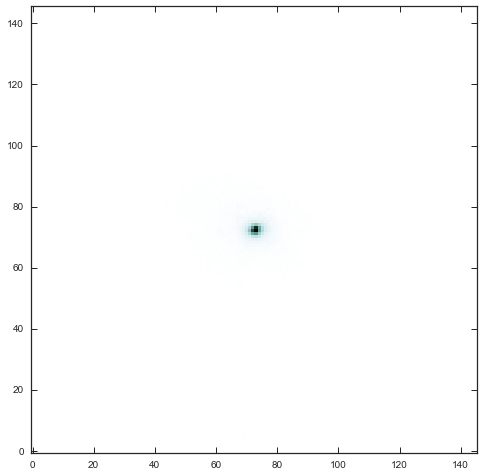

In [7]:
%matplotlib inline

beam_g102 = grizli.model.BeamCutout(sim_g102, sim_g102.object_dispersers[gal_id]['A'])

###show cutout
plt.figure(figsize=[8,8])
plt.imshow(beam_g102.beam.direct*(beam_g102.beam.seg == gal_id), interpolation='Nearest', cmap=colmap, origin='lower')
plt.show()
plt.close()

Create simluted grism

In [8]:
## read in spectra
wave, fl = Readfile('../BX418_spec.dat')

## normalize and redshift spectra
spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
spec = spec.redshift(7).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
spec.convert('flam')

## Compute the models
beam_g102.compute_model(spectrum_1d=[spec.wave,spec.flux])

## Extractions the model
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model,bin=0)

## Get sensitivity function
fwv, ffl = [beam_g102.beam.lam, beam_g102.beam.sensitivity / np.max(beam_g102.beam.sensitivity)]
filt = interp1d(fwv, ffl)

## Clip model to fit in interpolation, then remove sensitivity function
clip = []
for iii in range(len(w)):
    if fwv[0] < w[iii] < fwv[-1]:
        clip.append(iii)

w = w[clip]
f = f[clip]

f /= filt(w)

ID1=[U for U in range(len(w)) if 7900 < w[U] <11300]

Warning, 11 of 1541 bins contained negative fluxes; they have been set to zero.


Plot 2D and 1D spectra, compare 1D to original.

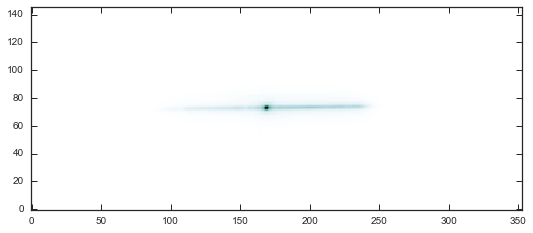

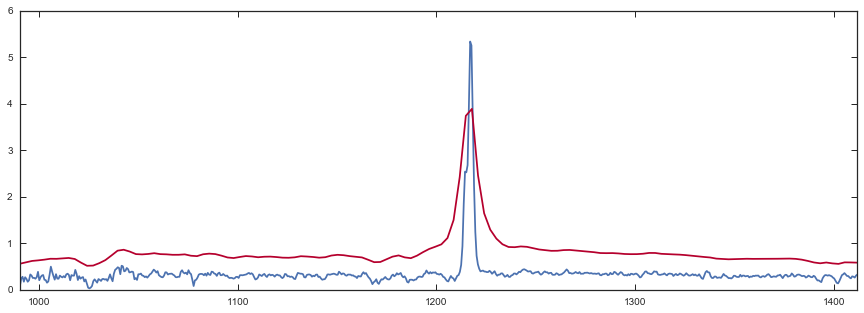

In [14]:
###Show Grism
plt.figure(figsize=[12,8])
plt.subplot(211)
plt.imshow(beam_g102.model, interpolation='Nearest', origin='lower', cmap=colmap)
plt.show()
plt.close()

###plot 1D spectra
plt.figure(figsize=[15,5])
plt.plot(wave,fl*2E16)
plt.plot(w[ID1]/8,f[ID1],color='#B5002D')
plt.xlim(min(w[ID1]/8),max(w[ID1]/8))
plt.show()
plt.close()